In [2]:
import torch
import torchvision


train_mnist = torchvision.datasets.MNIST(
    "./data",
    train=True,
    download=True,
    transform=torchvision.transforms.Compose([
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize((0.1307,), (0.3081,))
    ])
)

test_mnist = torchvision.datasets.MNIST(
    "./data",
    train=False,
    download=True,
    transform=torchvision.transforms.Compose([
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize((0.1307,), (0.3081,))
    ])
)


In [3]:
import random

class NumberPairs(torch.utils.data.IterableDataset):
    def __init__(self, dataset):
        super().__init__()
        self.dataset = dataset

    def __iter__(self):
        return self

    def __next__(self):
        a_digit, a_class = random.choice(self.dataset)
        b_digit, b_class = random.choice(self.dataset)
        
        return a_digit, b_digit, a_class, b_class

ds = NumberPairs(train_mnist)
for a, b, c, d in ds:
    print(a.shape, b.shape, c, d)
    break

torch.Size([1, 28, 28]) torch.Size([1, 28, 28]) 5 7


In [35]:
model = torch.nn.Sequential(
    torch.nn.Conv2d(1, 16, (3, 3), padding=1),
    torch.nn.LeakyReLU(),
    torch.nn.Conv2d(16, 32, (3, 3), padding=1),
    torch.nn.LeakyReLU(),
    torch.nn.MaxPool2d((2, 2)),
    torch.nn.Conv2d(32, 64, (3, 3)),
    torch.nn.LeakyReLU(),
    torch.nn.MaxPool2d((2, 2)),
    torch.nn.Conv2d(64, 64, (3, 3), stride=2),
    torch.nn.LeakyReLU(),
    torch.nn.Flatten(),
)

model.to("cuda")

for digit, cls in train_mnist:
    digit = digit.to("cuda")
    print(model(digit.unsqueeze(0)).shape)
    break

torch.Size([1, 256])


In [39]:
from tqdm import trange, tqdm

batches = 1000
ds = NumberPairs(train_mnist)
dl = torch.utils.data.DataLoader(ds, batch_size=32)

model.to("cuda")

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
dist_fn = torch.nn.PairwiseDistance(p=2)
loss_fn = torch.nn.MSELoss()

for epoch in range(3):
    bar = tqdm(enumerate(dl), total=batches)
    for i, (a_digits, b_digits, a_classes, b_classes) in bar:
        
        a_digits = a_digits.to("cuda")
        b_digits = b_digits.to("cuda")
        a_classes = a_classes.to("cuda")
        b_classes = b_classes.to("cuda")

        optimizer.zero_grad()
        a_outs = model(a_digits)
        b_outs = model(b_digits)

        dist = dist_fn(a_outs, b_outs)
        target_dists = (a_classes - b_classes).abs().float()
        
        loss = loss_fn(dist, target_dists)

        loss.backward()
        optimizer.step()

        bar.set_description(f"Loss {loss.item():.4f}")

        if i >= batches:
            break

Loss 1.9349: 100%|██████████| 1000/1000 [00:09<00:00, 105.17it/s]


In [40]:
train_dl = torch.utils.data.DataLoader(train_mnist, batch_size=32, shuffle=True)
test_dl = torch.utils.data.DataLoader(test_mnist, batch_size=32, shuffle=True)

train_features = []
train_classes = []

test_features = []
test_classes = []

for i, (digits, classes) in enumerate(train_dl):
    digits = digits.to("cuda")

    features = model(digits)
    train_features.append(features.detach().cpu().numpy())
    train_classes.append(classes.detach().cpu().numpy())

for i, (digits, classes) in enumerate(test_dl):
    digits = digits.to("cuda")

    features = model(digits)
    test_features.append(features.detach().cpu().numpy())
    test_classes.append(classes.detach().cpu().numpy())

In [41]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np

train_features = np.concatenate(train_features)
test_features = np.concatenate(test_features)

train_classes = np.concatenate(train_classes)
test_classes = np.concatenate(test_classes)

train_pca = PCA(n_components=2)
train_pca = train_pca.fit_transform(train_features)

test_pca = PCA(n_components=2)
test_pca = test_pca.fit_transform(test_features)

Text(0.5, 1.0, 'Test')

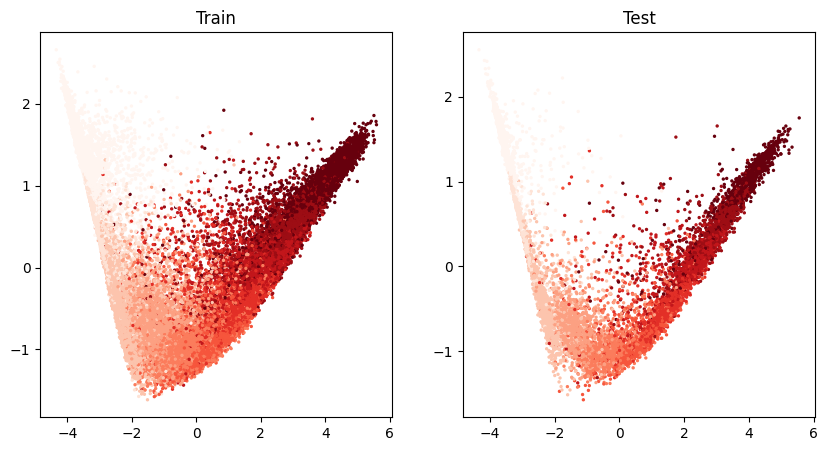

In [42]:

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].scatter(train_pca[:, 0], train_pca[:, 1], c=train_classes, s=2, cmap="Reds")
ax[0].set_title("Train")

ax[1].scatter(test_pca[:, 0], test_pca[:, 1], c=test_classes, s=2, cmap="Reds")
ax[1].set_title("Test")